# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, https://qaplib.mgi.polymtl.ca/

[3] NUG12, https://qaplib.mgi.polymtl.ca/data.d/nug12.dat

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [2]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug12.dat'

## QAP Problem (from wikipedia)
There are a set of n facilities and a set of n locations. For each pair of locations, a distance is specified and for each pair of facilities a weight or flow is specified (e.g., the amount of supplies transported between the two facilities). The problem is to assign all facilities to different locations with the goal of minimizing the sum of the distances multiplied by the corresponding flows.

## Reading input data

In [3]:
qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [6]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        # Bierzemy wiersz przepływu z budynku `i`, p[i] to lokacja do której przypisano budynek `i`, B[p[i], p] to odległości pomiędzy `i` a innymi budynkami
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [6]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = qap_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(qap_objective_function(p), p)

34.84866952896118
586.0 [ 1  9  5  4  0  7  6  3  2 10  8 11]


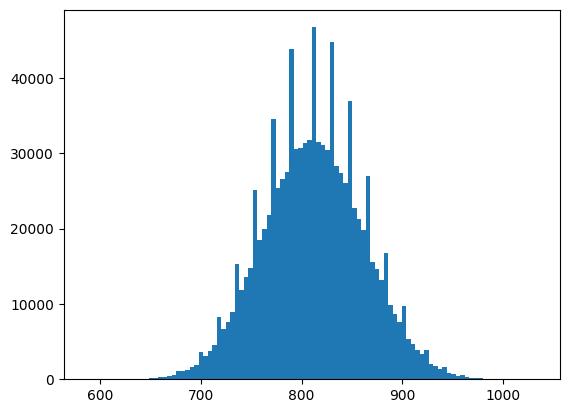

812.025434 49.74661931339298


In [7]:
plt.figure()
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [7]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [9]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = qap_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = qap_objective_function(q)
    if(q_cost < p_cost): # if q better then pick it
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)): # randomly choose worse to not get stuck in local area which might not have best maximum, further we go that chance is smaller
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

24.34701371192932 578.0


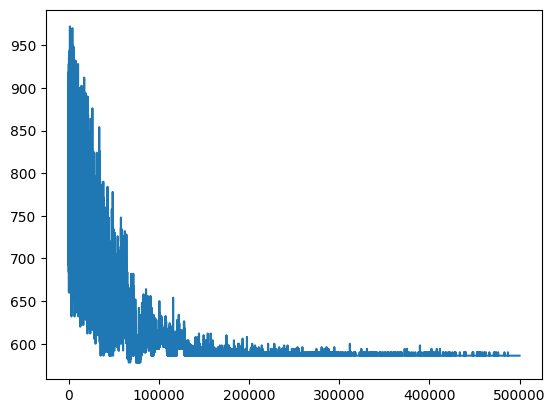

In [10]:
plt.figure()
plt.plot(costs)
plt.show()

### Zadanie 1

In [10]:
QAP_INSTANCE_URL = 'https://qaplib.mgi.polymtl.ca/data.d/nug14.dat' # 12, 14, 15, 16a, 16b, 17, 18, 20, 21, 22, 24, 25, 27, 28, 30

qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

Podpunkty b, c

In [12]:

T = 500_000
radius = 1
alpha = 1.00

t0 = time.time()
results_base = list()
for _ in range(100):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    accepts, successes = np.zeros(T+1), np.zeros(T+1)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost): # if q better then pick it
            p, p_cost = q, q_cost
            successes[t+1] = successes[t] + 1
            accepts[t+1] = accepts[t]
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)): # randomly choose worse to not get stuck in local area which might not have best maximum, further we go that chance is smaller
            p, p_cost = q, q_cost
            accepts[t+1] = accepts[t] + 1
            successes[t+1] = successes[t]
        else:
            accepts[t+1] = accepts[t]
            successes[t+1] = successes[t]
        costs[t] = p_cost
    results_base.append(costs.min())

print(time.time() - t0)

2777.540428876877


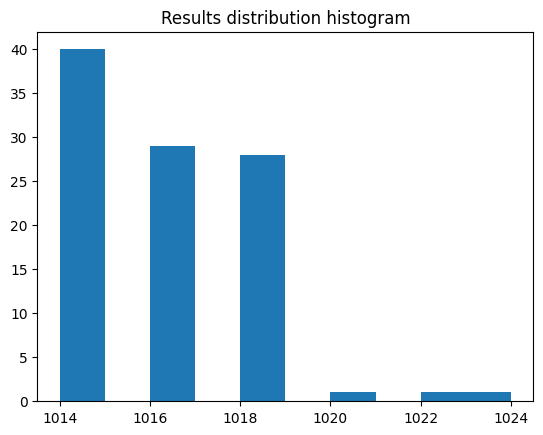

In [13]:
plt.figure()
plt.hist(results_base)
plt.title('Results distribution histogram')
plt.show()

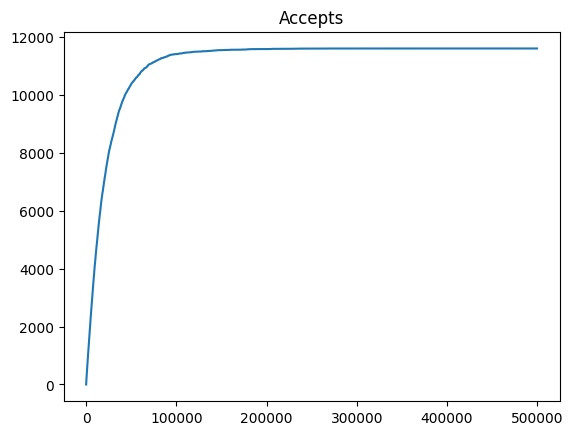

In [14]:
plt.figure()
plt.plot(accepts)
plt.title('Accepts')
plt.show()

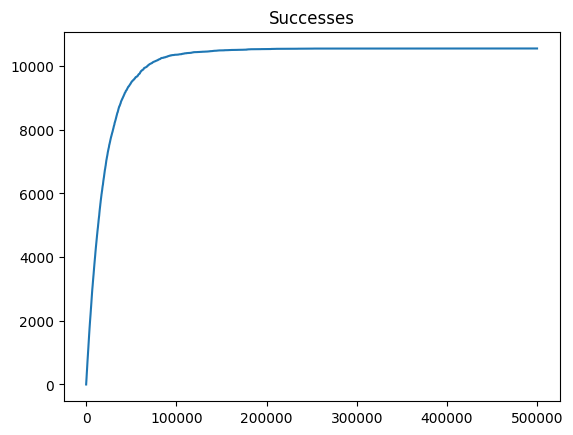

In [15]:
plt.figure()
plt.plot(successes)
plt.title('Successes')
plt.show()

Podpunkt d i e.

d) Dystans między permutacjami to może być ilość elementów które mają inne pozycje w tych permutacjach

e) Threshold acceptance, czyli zaakceptujemy gorszy stan pod warunkiem że jest gorszy o conajwyżej pewną wartość, spróbujemy ją również zmniejszać wraz z działaniem algorytmu. Eliminujemy tutaj element prawdopodobieństwa. Próbowałem jeszcze sposób gdzie "chłodziliśmy" algorytm logarytmicznie (a nie liniowo jak bazowo) ale wyniki wychodziły mi mega słabe, więc zostawiam tylko te bo tu nie jest najgorzej

In [1]:
def distance(p, q):
    dist = 0
    for i in range(len(p)):
        if p[i] != q[i]:
            dist += 1
    return dist

In [11]:

T = 500_000
radius = 1
alpha = 1.00

t0 = time.time()
results = list()
distances = list()
cost_diff = list()
for _ in range(100):
    initial_threshold = 50
    final_threshold = 1
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    accepts, successes = np.zeros(T+1), np.zeros(T+1)
    for t in range(T):
        threshold = initial_threshold - ((initial_threshold - final_threshold) / T) * t
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        if(q_cost < p_cost): # if q better then pick it
            distances.append(distance(p, q))
            cost_diff.append(p_cost - q_cost)
            p, p_cost = q, q_cost
            successes[t+1] = successes[t] + 1
            accepts[t+1] = accepts[t]
        else:
            if(q_cost - p_cost <= threshold):
                p, p_cost = q, q_cost
                accepts[t+1] = accepts[t] + 1
                successes[t+1] = successes[t]
            else:
                accepts[t+1] = accepts[t]
                successes[t+1] = successes[t]
        costs[t] = p_cost
    results.append(costs.min())

print(time.time() - t0)

2717.752468585968


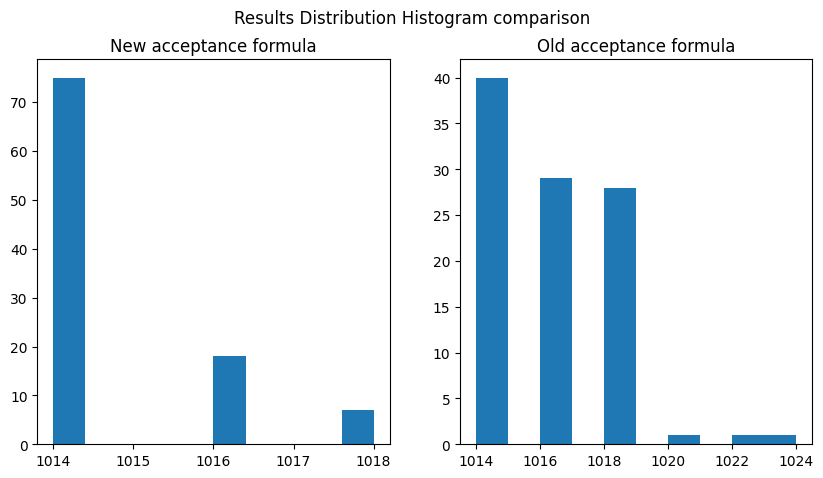

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(results)
plt.title('New acceptance formula')
plt.subplot(1, 2, 2)
plt.hist(results_base)
plt.title('Old acceptance formula')
plt.suptitle('Results Distribution Histogram comparison')
plt.show()

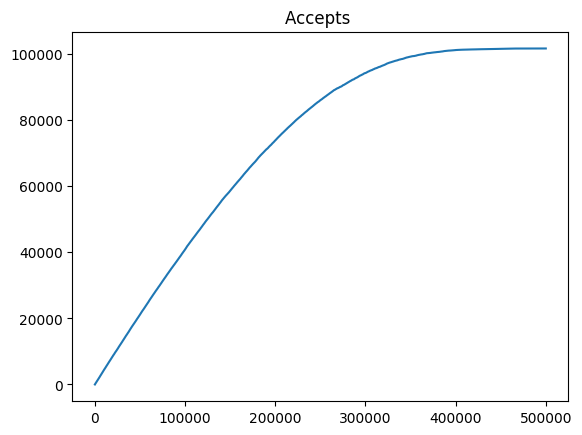

In [13]:
plt.figure()
plt.plot(accepts)
plt.title('Accepts ')
plt.show()

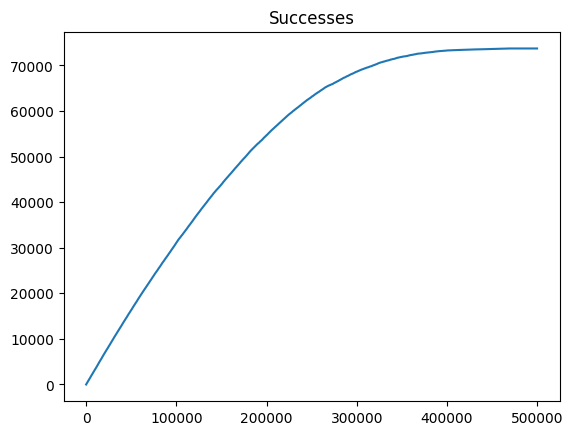

In [14]:
plt.figure()
plt.plot(successes)
plt.title('Successes')
plt.show()

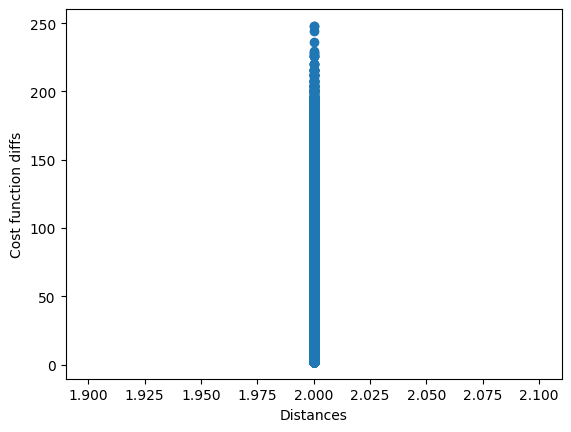

In [12]:
plt.scatter(distances, cost_diff)
plt.xlabel('Distances')
plt.ylabel('Cost function diffs')
plt.title('')
plt.show()

Komentarz do d)
Tutaj nie do końca rozumiem tego podpunktu? No wyzej jest zaleznosc między wartością (roznica) f(p) - f(q), a dystansem permutacji (wg. definicji dystansu jaką wybrałem i znałem), tyle że w naszym kodzie dystans między permutacjami p i q zawsze jest 2...., bo tak zdefiniowaliśmy stan sąsiadujący - zamieniamy losowo dwa elementy ze sobą w permutacji.

e) Podsumowanie:
Udało mi się ustawić thresholdy tak żeby uzyskać w miare zadowalające wyniki, dużo więcej wyników jest optymalnych, co chyba można ocenić jako ulepszenie algorytmu